# Tutorial 6: Convolutional Neural Networks (CNNs)

## Overview

Welcome to the Python Tutorial on Convolutional Neural Networks (CNNs)! In this comprehensive guide, we will dive into one of the most important and powerful deep learning architectures for image processing - CNNs. CNNs are designed to automatically and adaptively learn spatial hierarchies of features from input images.

CNNs have revolutionized computer vision tasks, such as image classification, object detection, segmentation, and more. In this tutorial, we will explore the fundamental concepts of CNNs, their architecture, and the mathematics behind their working. We will also walk through the implementation of CNNs in Python using popular deep learning libraries.

## Prerequisites

Before diving into this tutorial, it is recommended to have a solid understanding of the following topics:

- Python programming fundamentals
- Basics of machine learning and neural networks
- Linear algebra and calculus concepts - Understanding matrices, vectors, and derivatives will be beneficial for grasping CNNs.

Knowledge of libraries like NumPy, PyTorch, and Matplotlib will be helpful, as we will use them properly in our implementations and visualizations.

## What You'll Learn

By the end of this tutorial, you will:

- Understand the fundamental building blocks of Convolutional Neural Networks (CNNs).
- Comprehend the concept of convolution and its role in learning local patterns.
- Implement a basic CNN in Python using PyTorch, a popular deep learning framework.
- Train the CNN model on a dataset for image classification.

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Load Dataset and Create Dataloader

The `torchvision.datasets` module contains Dataset objects for many real-world vision data including MNIST, CIFAR, etc. In this tutorial, we use the MNIST dataset.

After downloading data, we also need to convert them into `Dataloader` class, which are ready to be used in training and validation loops of a CNN model.

```python
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
```

- The `DataLoader` class is used to create data loaders that provide batches of data during training and validation.
- `train_loader` and `test_loader` are created using DataLoader, and they represent the data loaders for the training and testing datasets, respectively.
- `BATCH_SIZE` is specified as an argument to the data loaders, determining the number of samples in each batch.
- `shuffle=True` for the training data loader ensures that the data is shuffled at the beginning of each epoch, which is essential for stochastic gradient descent.
- `shuffle=False` for the validation data loader means the data will not be shuffled to maintain the order of the data for evaluation.
- `num_workers=0` specifies the number of subprocesses used for data loading. Setting it to 0 means the data will be loaded in the main process.

**The code may take some time to download the first time it is executed.**

In [2]:
BATCH_SIZE = 64

# Loading MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

MNIST (Modified National Institute of Standards and Technology database) is a widely used collection of handwritten digits for training and testing image classification systems. It includes 60,000 training images and 10,000 test images, all in grayscale and 28x28 pixels in size. The following code shows the first batch of images in the training set.

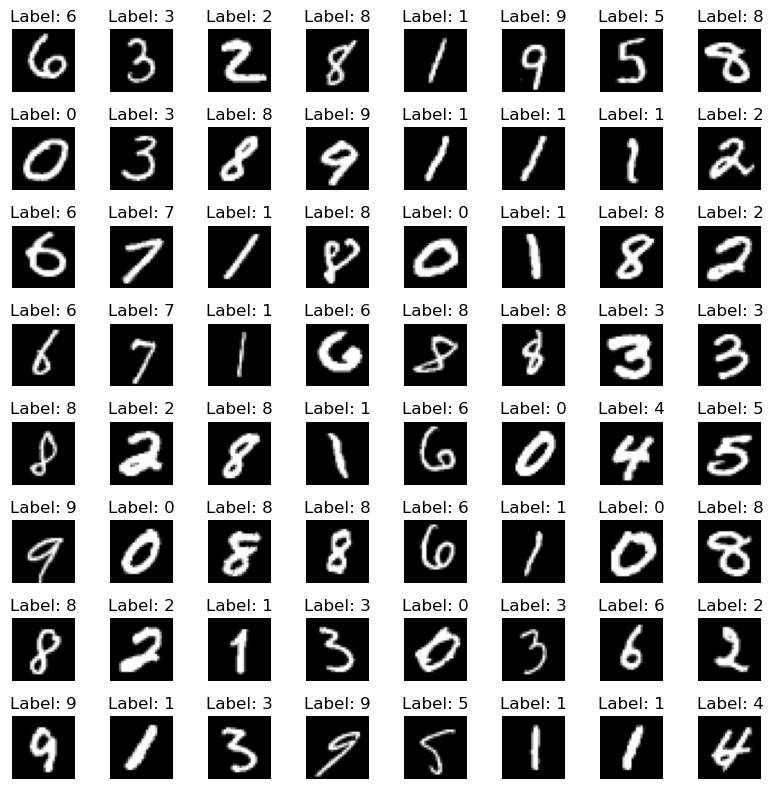

In [3]:
# Get the first batch of the training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure
grid_size = int(BATCH_SIZE**0.5)
rows, cols = grid_size, (BATCH_SIZE + grid_size - 1) // grid_size
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
axes = axes.flatten()

# Plot the images in the batch and their corresponding labels
for i, ax in enumerate(axes):
    if i < BATCH_SIZE:
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide the empty subplot

plt.tight_layout()
plt.show()

## Convolutional Neural Network (CNN)

### CNN model definition

```python
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
```

- The code defines a custom CNN class that inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch.
- The `__init__` method is the constructor that initializes the layers of the CNN model.
- The CNN model has three convolutional layers, each followed by a batch normalization layer.
- The `nn.Conv2d` layers define the convolutional operations. The first layer takes input channels (1 as MNIST is a grayscale dataset), has 16 output channels (16 filters), a kernel size of 5x5, a stride of 1, and padding of 0. The subsequent definition of the convolutional layer is similar.
- The `nn.ReLU` layers are used to activate the output of the convolutional layer and to introduce more nonlinearity into the model.
- The `nn.MaxPool2d` layer is used for max pooling with a kernel size of 2x2 and a stride of 2, effectively reducing the spatial dimensions by half.
- The final `nn.Linear` layer is the fully connected layer that maps the output of the convolutional layers to the number of classes in the dataset.

It should be emphasized that the `__init__` method **only defines the layers used in the convolutional network**, and the data does not necessarily flow in the order in which the layers are defined in the `__init__` method. Their flow order (forward propagation process) is defined in the forward method.

```python
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
```

- The `forward` method defines the forward pass of the CNN model, which takes the input tensor `x` (batch of images) as an argument.
- The input tensor has the shape `batch_size * 1 * 28 * 28`, where batch_size is the number of images in the batch, `1` is the number of channels (grey), and `28 * 28` is the image size.
- The tensor `x` undergoes a series of operations: convolution, batch normalization, ReLU activation, and max pooling in each convolutional block.
- After the convolutional blocks, the tensor is flattened using `x.view(batch_size, -1)` to convert it into a 1D vector to be passed through the fully connected layer.
- Finally, the tensor `x` is passed through the fully connected layer `self.fc1` to obtain the final output tensor of shape `batch_size * classes` (where `classes` is the number of output classes).

In [4]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,8,8)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

### Model instantiation, Optimizer, Loss function

Here we initialize a CNN model instance and define the optimization algorithm (SGD) used in the optimization process of the model. For classification problems, we use cross entropy as the loss function.

In [5]:
# define hyperparameters
LR = 0.001

model = CNN_Model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)  # optimize all cnn parameters
loss = nn.CrossEntropyLoss()  # define loss function
print(model)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


`torchinfo` is a handy tool that helps you summarize the shape of the output of each layer of a neural network. You can install this package via `%pip install torchinfo`. Or just skip the cell below.

In [6]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchinfo import summary
summary(model, (BATCH_SIZE, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 24, 24]          416
├─ReLU: 1-2                              [64, 16, 24, 24]          --
├─MaxPool2d: 1-3                         [64, 16, 12, 12]          --
├─Conv2d: 1-4                            [64, 32, 8, 8]            12,832
├─ReLU: 1-5                              [64, 32, 8, 8]            --
├─MaxPool2d: 1-6                         [64, 32, 4, 4]            --
├─Linear: 1-7                            [64, 10]                  5,130
Total params: 18,378
Trainable params: 18,378
Non-trainable params: 0
Total mult-adds (M): 68.22
Input size (MB): 0.20
Forward/backward pass size (MB): 5.77
Params size (MB): 0.07
Estimated Total Size (MB): 6.05

### Define Training Loop and Testing Loop
#### Training Loop
The training loop updates the model’s parameters based on the training dataset. It involves three key steps: **prediction**, **loss computation**, and **backpropagation**.

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Prediction
        pred = model(X)

        # Loss computation
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#### Testing Loop
The testing loop evaluates the model’s performance on a separate testing dataset, providing metrics like accuracy and average loss. In testing loop we
1. Use `model.eval()` ensures layers like dropout or batch normalization behave appropriately during evaluation.
2. Use `torch.no_grad` improves performance and avoids unnecessary computations as we don't need gradient information on test set

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Perform training and testing

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss, optimizer)
    test(test_loader, model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305893  [   64/60000]
loss: 2.283741  [ 6464/60000]
loss: 2.299510  [12864/60000]
loss: 2.279841  [19264/60000]
loss: 2.276711  [25664/60000]
loss: 2.255517  [32064/60000]
loss: 2.243817  [38464/60000]
loss: 2.237670  [44864/60000]
loss: 2.214646  [51264/60000]
loss: 2.221066  [57664/60000]
Test Error: 
 Accuracy: 33.8%, Avg loss: 2.208673 

Epoch 2
-------------------------------
loss: 2.203162  [   64/60000]
loss: 2.193577  [ 6464/60000]
loss: 2.178654  [12864/60000]
loss: 2.179673  [19264/60000]
loss: 2.117411  [25664/60000]
loss: 2.100324  [32064/60000]
loss: 2.059478  [38464/60000]
loss: 1.970136  [44864/60000]
loss: 1.911224  [51264/60000]
loss: 1.835386  [57664/60000]
Test Error: 
 Accuracy: 74.3%, Avg loss: 1.777294 

Epoch 3
-------------------------------
loss: 1.827572  [   64/60000]
loss: 1.694059  [ 6464/60000]
loss: 1.546942  [12864/60000]
loss: 1.326569  [19264/60000]
loss: 1.243754  [25664/60000]
loss: 1.116296  [32064/600

### Changing of model structure

We try to define neural networks of different structures for classification. Here we define a CNN with 18 convolutional layers stacked.

In [11]:
class ConvNet18(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(ConvNet18, self).__init__()
        
        # First convolutional layer with 2x2 pooling
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Final convolutional layer with 2x2 pooling
        self.conv_final = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Intermediate convolutional layers (64 channels, 16 layers total)
        self.conv_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding="same"),
                    nn.ReLU()
                )
                for _ in range(16)
            ]
        )
        
        # Fully connected layer
        self.fc = nn.Linear(64 * 7 * 7, num_classes)  # Output from conv_final: (64 channels, 7x7 feature map)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_layers(x)
        x = self.conv_final(x)
        x = torch.flatten(x, 1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x

In [12]:
very_deep_model = ConvNet18().to(device)
summary(very_deep_model, (BATCH_SIZE, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet18                                [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 64, 28, 28]          640
│    └─ReLU: 2-2                         [64, 64, 28, 28]          --
│    └─MaxPool2d: 2-3                    [64, 64, 14, 14]          --
├─Sequential: 1-2                        [64, 64, 14, 14]          --
│    └─Sequential: 2-4                   [64, 64, 14, 14]          --
│    │    └─Conv2d: 3-1                  [64, 64, 14, 14]          36,928
│    │    └─ReLU: 3-2                    [64, 64, 14, 14]          --
│    └─Sequential: 2-5                   [64, 64, 14, 14]          --
│    │    └─Conv2d: 3-3                  [64, 64, 14, 14]          36,928
│    │    └─ReLU: 3-4                    [64, 64, 14, 14]          --
│    └─Sequential: 2-6                   [64, 64, 14, 14]          --
│    │

The results show that due to the gradient vanishing problem caused by the superposition of deep convolutional networks, the training effect of the model is far worse than that of shallow networks. In addition, the performance of the model has hardly changed during training.

In [13]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(very_deep_model.parameters(), lr=LR)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, very_deep_model, loss, optimizer)
    test(test_loader, very_deep_model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302402  [   64/60000]
loss: 2.302047  [ 6464/60000]
loss: 2.303234  [12864/60000]
loss: 2.304471  [19264/60000]
loss: 2.302051  [25664/60000]
loss: 2.302191  [32064/60000]
loss: 2.302608  [38464/60000]
loss: 2.305934  [44864/60000]
loss: 2.303200  [51264/60000]
loss: 2.302357  [57664/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.302048 

Epoch 2
-------------------------------
loss: 2.303334  [   64/60000]
loss: 2.301492  [ 6464/60000]
loss: 2.300645  [12864/60000]
loss: 2.305054  [19264/60000]
loss: 2.300226  [25664/60000]
loss: 2.304907  [32064/60000]
loss: 2.303755  [38464/60000]
loss: 2.298477  [44864/60000]
loss: 2.302033  [51264/60000]
loss: 2.298237  [57664/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301714 

Epoch 3
-------------------------------
loss: 2.305441  [   64/60000]
loss: 2.295955  [ 6464/60000]
loss: 2.305464  [12864/60000]
loss: 2.301111  [19264/60000]
loss: 2.302230  [25664/60000]
loss: 2.299023  [32064/600

## Alignment between Layers
Similar to ANN, there are strict alignment requirements between layers when defining CNN.

- For convolutional (or pooling) layers, the number of output channels of the previous convolutional layer and the number of input channels of the next convolutional layer should be the same.
- Between convolutional and linear layers:
    - If simple `flatten` is used, the number of inputs to the linear layer should be equal to the number of channels of the convolutional layer * feature map width * feature map height.
    - If `AdaptiveAvgPool` is used, the number of inputs to the linear layer should be equal to the number of channels of the convolutional layer.

Here we define a CNN model where `maxpool1` and `conv2` are not aligned

In [14]:
class UnalignedCNN(nn.Module):
    def __init__(self):
        super(UnalignedCNN, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) # output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=15, out_channels=32, kernel_size=5, stride=1, padding=0) # [NOTE]: the previous layer has 16 channels output, but we only use 15 channels as input
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

When doing the forward pass, misaligned layers will result in a RuntimeError.

In [15]:
unalignedCNN = UnalignedCNN()
try:
    unalignedCNN(torch.randn(1, 1, 28, 28))
except RuntimeError as e:
    print(e)

Given groups=1, weight of size [32, 15, 5, 5], expected input[1, 16, 12, 12] to have 15 channels, but got 16 channels instead


You can try to change the `input_channel` definition of `conv2` in `UnalignedCNN` to make it work properly.

## ResNet-18

ResNet has effectively alleviated the gradient vanishing problem of deep networks and has profoundly influenced the design of subsequent deep neural networks. Next, we will try to build a ResNet18 model to classify MNIST.

First, define the basic module of ResNet: Residual. This code generates two types of networks: one in whic hthe input is added to the output before applying the ReLU nonlinearity when `use_1x1conv=False`, and another in which the channels and resolution are adjusted by adding convolutions when `use_1x1conv=True`.

In [16]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        y += x
        return F.relu(y)

Next, we define the residual blocks. Each block uses several Residuals with the same number of output channels. The number of channels in the first block is the same as the number of input channels. Since the maximum pooling layer with a stride of 2 has been used before, there is no need to reduce the height and width. In each subsequent block, the number of channels of the previous block is doubled in the first residual block, and the height and width are halved.

In [17]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

ResNet stacks all residual blocks, where each block uses 2 Residuals. Finally, a global average pooling layer and a fully connected layer output are added. Each block has 4 convolutional layers (excluding the 1x1 convolutional layers). Including the first convolutional layer and the last fully connected layer, there are 18 layers in total. Therefore, this model is often called ResNet-18. Different ResNet models can be obtained by configuring different numbers of channels and residual blocks in the module, such as the deeper ResNet-152 with 152 layers.

In [18]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*resnet_block(64, 128, 2))
        self.b4 = nn.Sequential(*resnet_block(128, 256, 2))
        self.b5 = nn.Sequential(*resnet_block(256, 512, 2))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        return x

In [19]:
resNet = ResNet18().to(device)
summary(resNet, (BATCH_SIZE, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 64, 14, 14]          3,200
│    └─BatchNorm2d: 2-2                  [64, 64, 14, 14]          128
│    └─ReLU: 2-3                         [64, 64, 14, 14]          --
│    └─MaxPool2d: 2-4                    [64, 64, 7, 7]            --
├─Sequential: 1-2                        [64, 64, 7, 7]            --
│    └─Residual: 2-5                     [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-1                  [64, 64, 7, 7]            36,928
│    │    └─BatchNorm2d: 3-2             [64, 64, 7, 7]            128
│    │    └─Conv2d: 3-3                  [64, 64, 7, 7]            36,928
│    │    └─BatchNorm2d: 3-4             [64, 64, 7, 7]            128
│    └─Residual: 2-6                     [64, 64, 7, 7]            --
│

Tests show that by adding a residual module, the gradient can be easily back-propagated, so we can use very deep convolutional networks and achieve better training results than shallow networks.

In [20]:
optimizer = torch.optim.SGD(resNet.parameters(), lr=LR)
loss = nn.CrossEntropyLoss()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, resNet, loss, optimizer)
    test(test_loader, resNet, loss)

Epoch 1
-------------------------------
loss: 2.557467  [   64/60000]
loss: 0.454128  [ 6464/60000]
loss: 0.168154  [12864/60000]
loss: 0.219414  [19264/60000]
loss: 0.166700  [25664/60000]
loss: 0.156458  [32064/60000]
loss: 0.260591  [38464/60000]
loss: 0.141104  [44864/60000]
loss: 0.185161  [51264/60000]
loss: 0.030336  [57664/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.089451 

Epoch 2
-------------------------------
loss: 0.075313  [   64/60000]
loss: 0.098215  [ 6464/60000]
loss: 0.108149  [12864/60000]
loss: 0.036165  [19264/60000]
loss: 0.056766  [25664/60000]
loss: 0.084451  [32064/60000]
loss: 0.057508  [38464/60000]
loss: 0.029155  [44864/60000]
loss: 0.042121  [51264/60000]
loss: 0.025289  [57664/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.064442 

Epoch 3
-------------------------------
loss: 0.043924  [   64/60000]
loss: 0.059496  [ 6464/60000]
loss: 0.050436  [12864/60000]
loss: 0.036044  [19264/60000]
loss: 0.033108  [25664/60000]
loss: 0.016095  [32064/600

## Graph Convolutional Neural Network (GNN)

In the following sections we will use PyTorch Geometric to build a graph convolutional network to classify scientific papers. First you can find out how to install PyTorch Geometric [Here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html), a library built upon PyTorch to easily write and train GNNs.

In [22]:
%pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

We use Cora dataset for demonstration in this tutorial. The Cora dataset is one of the most commonly used benchmark datasets for research in GNNs. It represents a citation network where nodes correspond to scientific papers, and edges represent citation relationships between these papers. Each node is associated with a high-dimensional sparse feature vector representing the content of the corresponding paper. Specifically, the features are based on a Bag-of-Words (BOW) representation, consisting of 1,433 binary attributes indicating the presence or absence of specific words in the paper. Each node is labeled with one of seven classes, representing the topic of the paper, such as artificial intelligence, computer vision, or information retrieval. 

We can quickly download the Cora dataset through `torch_geometric.datasets.Planetoid()` and organize it into the format required by pyg.

In [23]:
dataset = Planetoid(root='./data/Cora', name='Cora')
data, num_node_features, num_classes = dataset[0].to(device), dataset.num_node_features, dataset.num_classes
print(num_node_features, num_classes)

1433 7


Next, we define a graph convolutional network with three graph convolutional layers. 

- `torch_geometric.nn.GCNConv(in_channels, out_channels)` is used to define a graph convolutional layer with `in_channels` input features and `out_channels` output features
- Each convolutional layer uses the ReLU function to activate.
- A Dropout layer with a probability of 0.3 is added after the first two convolutional layers to suppress overfitting.

In [24]:
class GCN(nn.Module):
    def __init__(self, features, hidden_dimension, classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(features, hidden_dimension)
        self.conv2 = GCNConv(hidden_dimension, hidden_dimension)
        self.conv3 = GCNConv(hidden_dimension, classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training, p=0.3)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training, p=0.3)
        x = self.conv3(x, edge_index)
        return x

Here we initialize a GCN model instance with 32 hidden channels and define the optimization algorithm (Adam) used in the optimization process of the model. For classification problems, we use cross entropy as the loss function.

In [25]:
hidden_dimension = 32
gcn_model = GCN(num_node_features, hidden_dimension, num_classes).to(device)

learn_rate = 0.01
weight_decay = 5e-4
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=learn_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

Here we train the model. After each epoch of training, we use the validation set to output the precision, recall, f1 score, and loss function value and record them. After training, we calculate the precision, recall, and f1 score on the test set and output them.

In [26]:
precisions, recalls, f1s, losses = [], [], [], []
for epoch in range(200):
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    gcn_model.eval()
    _, predicted_val = torch.max(out[data.val_mask], dim=1)
    predicted_val = predicted_val.cpu().detach().numpy()
    precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(data.y[data.val_mask].cpu().detach().numpy(), 
                                                                           predicted_val, average='macro', zero_division=0)
    precisions.append(precision_val)
    recalls.append(recall_val)
    f1s.append(f1_val)
    print(f"Epoch {epoch:<3d} | precision_val: {precision_val:.4f}, recall_val: {recall_val:.4f}, f1_val: {f1_val:.4f}, loss: {loss.item():.4f}")

_, predicted_test = torch.max(out[data.test_mask], dim=1)
predicted_test = predicted_test.cpu().detach().numpy()
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(data.y[data.test_mask].cpu().detach().numpy(), 
                                                                        predicted_test, average='macro', zero_division=0)
print(f"Final Test precision: {precision_test:.4f}, recall: {recall_test:.4f}, f1: {f1_test:.4f}")

Epoch 0   | precision_val: 0.0432, recall_val: 0.1188, f1_val: 0.0473, loss: 1.9500
Epoch 1   | precision_val: 0.4904, recall_val: 0.3776, f1_val: 0.2996, loss: 1.8815
Epoch 2   | precision_val: 0.6818, recall_val: 0.4121, f1_val: 0.3669, loss: 1.7694
Epoch 3   | precision_val: 0.7167, recall_val: 0.4259, f1_val: 0.3641, loss: 1.6191
Epoch 4   | precision_val: 0.6717, recall_val: 0.4479, f1_val: 0.3687, loss: 1.4463
Epoch 5   | precision_val: 0.7011, recall_val: 0.5187, f1_val: 0.4527, loss: 1.2462
Epoch 6   | precision_val: 0.6563, recall_val: 0.5741, f1_val: 0.5183, loss: 1.0707
Epoch 7   | precision_val: 0.6502, recall_val: 0.6801, f1_val: 0.6274, loss: 0.9007
Epoch 8   | precision_val: 0.6496, recall_val: 0.7117, f1_val: 0.6483, loss: 0.7175
Epoch 9   | precision_val: 0.6961, recall_val: 0.7536, f1_val: 0.7109, loss: 0.5981
Epoch 10  | precision_val: 0.7077, recall_val: 0.7556, f1_val: 0.7238, loss: 0.4771
Epoch 11  | precision_val: 0.7366, recall_val: 0.7673, f1_val: 0.7452, loss:

Finally, we visualized the changes in various metrics during the training process.

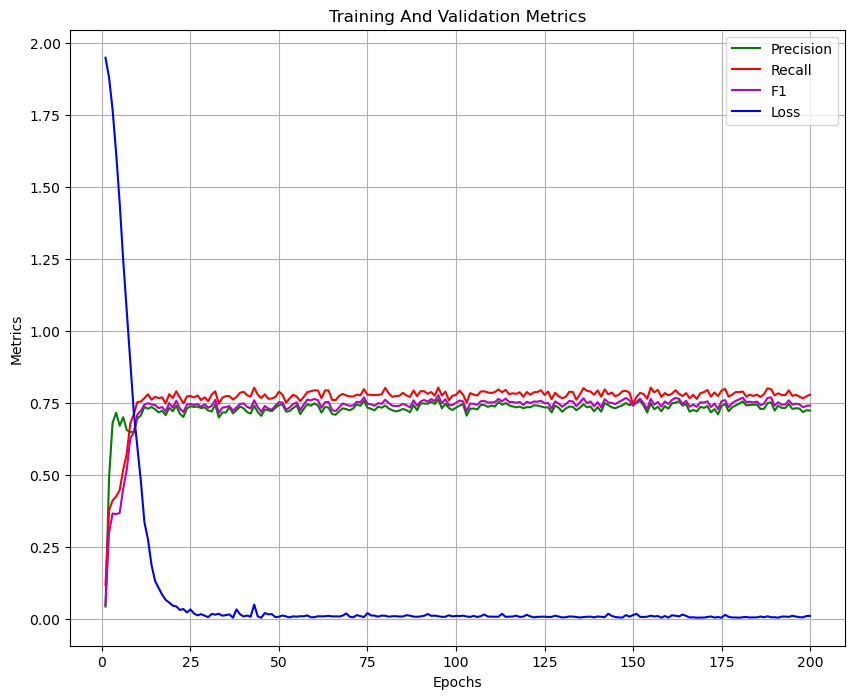

In [27]:
epochs = range(1, len(precisions)+1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, precisions, 'g', label='Precision')
plt.plot(epochs, recalls, 'r', label='Recall')
plt.plot(epochs, f1s, 'm', label='F1')
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Training And Validation Metrics')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Attention

The following code demonstrates the use of the ATTENTION mechanism to regress a noisy nonlinear dataset.

Epoch 100/1500, Loss: 0.5093
Epoch 200/1500, Loss: 0.4394
Epoch 300/1500, Loss: 0.3083
Epoch 400/1500, Loss: 0.1828
Epoch 500/1500, Loss: 0.1345
Epoch 600/1500, Loss: 0.1217
Epoch 700/1500, Loss: 0.1116
Epoch 800/1500, Loss: 0.1022
Epoch 900/1500, Loss: 0.0935
Epoch 1000/1500, Loss: 0.0858
Epoch 1100/1500, Loss: 0.0791
Epoch 1200/1500, Loss: 0.0731
Epoch 1300/1500, Loss: 0.0679
Epoch 1400/1500, Loss: 0.0633
Epoch 1500/1500, Loss: 0.0592


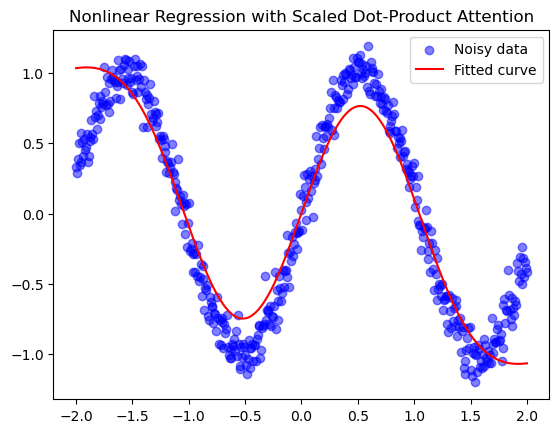

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

np.random.seed(42)
x = np.linspace(-2, 2, 500)
y = np.sin(3 * x) + 0.1 * np.random.normal(size=x.shape)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class NonlinearDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = NonlinearDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, q, k, v):
        dk = torch.tensor(q.size(-1))
        scores = -1 / 2 * torch.cdist(q, k, p=2).pow(2) / torch.sqrt(dk)
        attention = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention, v)
        return output

class AttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionRegressor, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.attention = ScaledDotProductAttention()
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, v):
        q = self.query(x)
        k = self.key(x)
        v = self.value(v)
        attn_output = self.attention(q, k, v)
        output = self.fc(attn_output)
        return output

model = AttentionRegressor(input_dim=1, hidden_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1500
for epoch in range(epochs):
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_x, batch_y)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(x_tensor, y_tensor).numpy()

plt.scatter(x, y, color='blue', alpha=0.5, label='Noisy data')
plt.plot(x, y_pred, color='red', label='Fitted curve')
plt.legend()
plt.title('Nonlinear Regression with Scaled Dot-Product Attention')
plt.show()